In [79]:
# Data Visualization
import matplotlib.pyplot as plt

# Data Manipulation
import numpy as np
import pandas as pd

# Word2Vec Loading
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


from collections import Counter

In [3]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [4]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [5]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

Retrieved from WikiData using
```sparql
SELECT DISTINCT (lcase(?male) as ?maleL) (lcase(?female) as ?femaleL)
WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
      ?item wdt:P2521 ?female.
      ?item wdt:P3321 ?male.
      FILTER(LANG(?female) = "en").
      FILTER(LANG(?male) = "en").
      FILTER(?male != ?female)
} ORDER BY DESC(?item)
```

In [6]:
male_female = pd.read_csv('male_female.csv').apply(lambda x: x.str.lower())
male_female = male_female.replace(' ', '_', regex=True)
male_female = male_female.drop_duplicates(subset='maleL', keep=False).drop_duplicates(subset='femaleL', keep=False)

In [7]:
male_female_model: pd.DataFrame = male_female[male_female.isin(t).all(axis=1)]

Retrieved from WikiData using
```sparql
SELECT DISTINCT ?countryLabel ?capitalLabel
WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
      ?country wdt:P31 wd:Q6256;
               wdt:P36 ?capital.
} ORDER BY DESC(?country)
```

In [8]:
country_capital = pd.read_csv('country_capital.csv').apply(lambda x: x.str.lower())
country_capital = country_capital.replace(' ', '_', regex=True)
country_capital = country_capital.drop_duplicates(subset='countryLabel', keep=False)
country_capital = country_capital.drop(index=country_capital[country_capital['countryLabel'] == country_capital['capitalLabel']].index)

In [9]:
country_capital_model: pd.DataFrame = country_capital[country_capital.isin(t).all(axis=1)]
country_capital_model = country_capital_model.sort_values(by=['countryLabel'], key=lambda x: pd.Series(w2v_model.key_to_index)[x]).reset_index(drop=True).loc[:male_female_model.shape[0]-1]

In [10]:
# Combine all words from all 4 categories (male, female, country, capital)
words = pd.concat([male_female_model.melt()['value'], country_capital_model.melt()['value']]).reset_index(drop=True)

In [11]:
# Get vectors for the words (shape 164, 300)
word_vecs = np.vstack(words.apply(vec))

In [12]:
# Get all combinations (indices of a triangular matrix, excluding the diagonal with an offset of 1)
i, j = np.triu_indices(words.shape[0], 1)

In [13]:
# Subtract the words from each other to create a relationship vector
word_pair_vecs = word_vecs[i] - word_vecs[j]

# Half of the vectors will be the wrong way (for example, some will be country-capital, while others will be capital-country)
# They will be on opposite sides of any hyperplane, so we choose a hyperplane and flip everything on the wrong side of it
# Commented out because the way they're paired right now, this never happens
# word_pair_vecs[word_pair_vecs[:, 0] < 0] = -word_pair_vecs[word_pair_vecs[:, 0] < 0]

In [14]:
word_pairs = pd.DataFrame([words[i].reset_index(drop=True), words[j].reset_index(drop=True)], index=['word1', 'word2']).T

In [15]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', PCA(n_components=2, random_state=42))
])

transform = pipe.fit_transform(word_pair_vecs)

In [16]:
# Find all pairs that make sense; there's a total of 41 + 41 = 82 of them
mf_pairs = transform[(i < 82) & (j < 82) & (i+41 == j)]
cc_pairs = transform[(i >= 82) & (j >= 82) & (i+41 == j)]

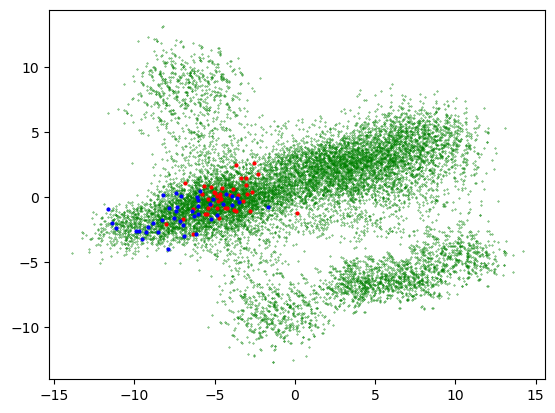

In [17]:
# plt.scatter(cc_pairs[:, 0], cc_pairs[:, 1], c='b', label='country/capital')
# plt.scatter(transform[:, 0], transform[:, 1])
plt.scatter(transform[:, 0], transform[:, 1], c='g', s=0.1, label='other')
plt.scatter(mf_pairs[:, 0], mf_pairs[:, 1], c='r', s=4, label='male/female')
plt.scatter(cc_pairs[:, 0], cc_pairs[:, 1], c='b', s=4, label='country/capital')

In [83]:
kmeans = KMeans(n_clusters=32, random_state=42).fit(word_pair_vecs)

/Users/trevor/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [84]:
silhouette_score(word_pair_vecs, kmeans.fit_predict(word_pair_vecs))

/Users/trevor/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.07392305

In [85]:
pairs = kmeans.labels_[i+41 == j]
Counter(pairs)

Counter({15: 16,
         3: 11,
         8: 10,
         22: 9,
         28: 7,
         2: 7,
         27: 6,
         11: 4,
         30: 3,
         10: 2,
         24: 2,
         4: 2,
         5: 2,
         26: 2,
         25: 2,
         29: 2,
         14: 2,
         17: 2,
         20: 2,
         21: 2,
         19: 1,
         16: 1,
         0: 1,
         18: 1,
         9: 1,
         6: 1,
         31: 1,
         1: 1})

In [91]:
word_pairs[kmeans.labels_ == 15]

,word1,word2
326,actor,king
328,actor,prior
332,actor,duke
333,actor,goodman
334,actor,count
...,...,...
12741,islamabad,berlin
12744,islamabad,rome
12749,islamabad,cairo
12988,amman,rome


In [49]:
for i in range(0, 63):
    word_pairs[kmeans.labels_==i]

In [65]:
word_pairs[kmeans.labels_==0]

,word1,word2
2926,ogre,yogi
2927,ogre,godbrother
2928,ogre,prince
2929,ogre,son
2930,ogre,uncle
...,...,...
3065,ogre,vienna
3066,ogre,copenhagen
3067,ogre,lima
3068,ogre,helsinki


In [21]:
w2v_model.most_similar(positive=['mother', 'businessman'], negative=['father'])

[('businesswoman', 0.7828382849693298),
 ('entrepreneur', 0.5662969946861267),
 ('housewife', 0.5576657056808472),
 ('Businessman', 0.5546095967292786),
 ('woman', 0.5489617586135864),
 ('businesman', 0.5328840017318726),
 ('businessperson', 0.5321270823478699),
 ('resident', 0.5286872982978821),
 ('schoolteacher', 0.5228217244148254),
 ('restaurateur', 0.5167855620384216)]

In [22]:
w2v_model.most_similar(positive=['actress', 'businessman'], negative=['father'])

[('businesswoman', 0.6089984774589539),
 ('actor', 0.5787507891654968),
 ('Actress', 0.5160931348800659),
 ('socialite', 0.48045045137405396),
 ('songstress', 0.47421637177467346),
 ('comedienne', 0.4685734510421753),
 ('actresses', 0.46831855177879333),
 ('thesp', 0.46185967326164246),
 ('politician', 0.45722687244415283),
 ('actress_Andie_MacDowell', 0.4430975317955017)]

In [23]:
w2v_model.most_similar(positive=['actress'])

[('actor', 0.7930010557174683),
 ('Actress', 0.7470887899398804),
 ('actresses', 0.7134618163108826),
 ('actress_Rachel_Weisz', 0.6638520359992981),
 ('Best_Actress', 0.6395923495292664),
 ('singer', 0.6364269852638245),
 ('CATE_BLANCHETT', 0.6363811492919922),
 ('actresss', 0.6308683753013611),
 ('blonde_beauty', 0.6293762922286987),
 ('thesp', 0.6286961436271667)]

In [24]:
w2v_model.similarity('mother', 'actress')

0.42112362

In [25]:
w2v_model.similarity('father', 'businessman')

0.41853

In [28]:
w2v_model.most_similar(positive=['businessman'], negative=['man'])

[('entrepreneur', 0.42547309398651123),
 ('businessmen', 0.42060863971710205),
 ('George_Behrakis', 0.40702372789382935),
 ('industrialist', 0.39802905917167664),
 ('wealthy_businessman', 0.3973967134952545),
 ('Beijing_AustChina_Technology', 0.390698105096817),
 ('venture_capitalist', 0.39069175720214844),
 ('tycoon', 0.3837265968322754),
 ('Businessman', 0.3836364448070526),
 ('Louis_Beecherl', 0.38110217452049255)]

In [27]:
male_female_model

,maleL,femaleL
4,businessman,businesswoman
5,emperor,empress
6,actor,actress
7,brother,sister
8,king,queen
11,newspaperman,newspaperwoman
16,prior,prioress
23,nephew,niece
24,batsman,batswoman
31,salesman,saleswoman


In [28]:
country_capital_model

,countryLabel,capitalLabel
0,turkey,ankara
1,canada,ottawa
2,australia,canberra
3,england,london
4,iraq,baghdad
5,pakistan,islamabad
6,japan,tokyo
7,israel,jerusalem
8,nigeria,abuja
9,france,paris


In [ ]:
w2v_model.most_similar(positive=[mf_pairs])